In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Basic Information

In [72]:
song_data = pd.read_csv("./data/song_data.csv")

In [73]:
song_data.shape

(18835, 15)

In [74]:
song_data.columns

Index(['song_name', 'song_popularity', 'song_duration_ms', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'audio_mode', 'speechiness', 'tempo', 'time_signature',
       'audio_valence'],
      dtype='object')

In [75]:
song_data.dtypes

song_name            object
song_popularity       int64
song_duration_ms      int64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
audio_mode            int64
speechiness         float64
tempo               float64
time_signature        int64
audio_valence       float64
dtype: object

In [76]:
song_data.describe()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,18835.000000,1.883500e+04,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000
mean,52.991877,2.182116e+05,0.258539,0.633348,0.644995,0.078008,5.289196,0.179650,-7.447435,0.628139,0.102099,121.073154,3.959119,0.527967
std,21.905654,5.988754e+04,0.288719,0.156723,0.214101,0.221591,3.614595,0.143984,3.827831,0.483314,0.104378,28.714456,0.298533,0.244632
min,0.000000,1.200000e+04,0.000001,0.000000,0.001070,0.000000,0.000000,0.010900,-38.768000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,1.843395e+05,0.024100,0.533000,0.510000,0.000000,2.000000,0.092900,-9.044000,0.000000,0.037800,98.368000,4.000000,0.335000
50%,56.000000,2.113060e+05,0.132000,0.645000,0.674000,0.000011,5.000000,0.122000,-6.555000,1.000000,0.055500,120.013000,4.000000,0.527000
75%,69.000000,2.428440e+05,0.424000,0.748000,0.815000,0.002570,8.000000,0.221000,-4.908000,1.000000,0.119000,139.931000,4.000000,0.725000
max,100.000000,1.799346e+06,0.996000,0.987000,0.999000,0.997000,11.000000,0.986000,1.585000,1.000000,0.941000,242.318000,5.000000,0.984000


We can see through the number of unique values that there are duplicated songs in the dataset ($18335$ rows, but only $13070$ songs), so we need to  deduplicate the data first in data preprocessing. 

In [77]:
song_data.nunique().sort_values()

audio_mode              2
time_signature          5
key                    12
song_popularity       101
danceability          849
energy               1132
speechiness          1224
audio_valence        1246
liveness             1425
acousticness         3209
instrumentalness     3925
loudness             8416
song_duration_ms    11771
tempo               12112
song_name           13070
dtype: int64

# Data preprocessing

We first drop duplicated rows, and then drop the column of song names, as they are not suitble features (strings) for our purpose of data analysis.

Here we notice that there are $14926$ songs remaining, while there are $13070$ songs. This may indicate different songs with the same name, so we may keep all of them.

   song_popularity  song_duration_ms  acousticness  danceability  energy  \
0               73            262333      0.005520         0.496   0.682   
1               66            216933      0.010300         0.542   0.853   
2               76            231733      0.008170         0.737   0.463   
3               74            216933      0.026400         0.451   0.970   
4               56            223826      0.000954         0.447   0.766   

   instrumentalness  key  liveness  loudness  audio_mode  speechiness  \
0          0.000029    8    0.0589    -4.095           1       0.0294   
1          0.000000    3    0.1080    -6.407           0       0.0498   
2          0.447000    0    0.2550    -7.828           1       0.0792   
3          0.003550    0    0.1020    -4.938           1       0.1070   
4          0.000000   10    0.1130    -5.065           1       0.0313   

     tempo  time_signature  audio_valence  
0  167.060               4          0.474  
1  105.256      

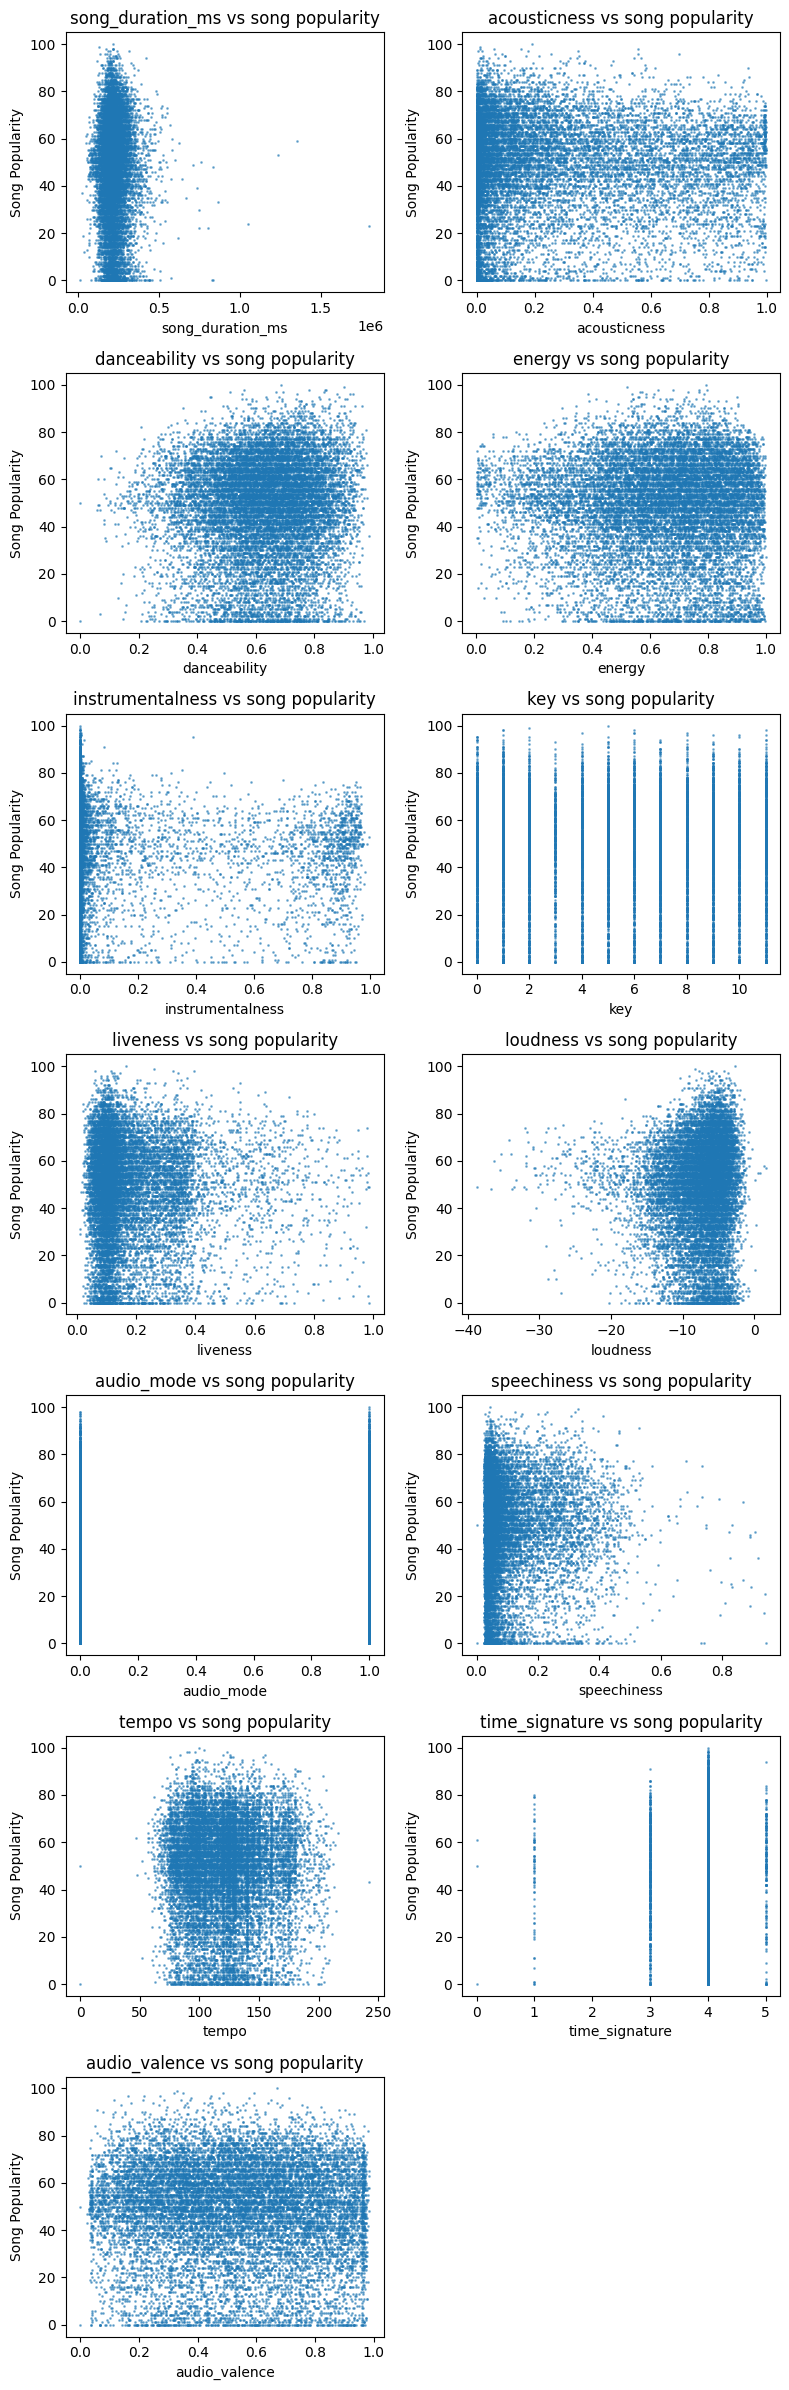

In [78]:
# Drop duplicated rows and remove the 'song_name' column
song_data = song_data.drop_duplicates().drop(columns=['song_name'])
print(song_data.head())

# Features to plot against 'song_popularity'
features = song_data.columns.drop('song_popularity')

# # Create scatter plots for each feature against 'song_popularity'
plt.figure(figsize=(8, 24))
for i, feature in enumerate(features, 1):
    plt.subplot(7, 2, i)  # Create grid of subplots
    plt.scatter(song_data[feature], song_data['song_popularity'], alpha=0.5, s=1)
    plt.title(f'{feature} vs song popularity')
    plt.xlabel(feature)
    plt.ylabel('Song Popularity')
    plt.tight_layout()

plt.show()

## Handling missing data

We can see through below that there is no missing value in all features and outcome. This means that we are free from handling missing valies.

In [30]:
song_data.isna().sum()

song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

## One-hot encoding

Notice that the features key, audio mode, and time signiture are categorical, meaning that the relevant magnitude of the features has no meaning to our model.

Based on the encoding result, at most one of the encoded column for each feature could be $1$. If all the columns corresponding to a column is $0$, then it means that the corresponding one-hot-encoded feature has value $0$.

In [31]:
# Features to one-hot encode
categorical_features = ['key', 'audio_mode', 'time_signature']

# Perform one-hot encoding
song_data_encoded = pd.get_dummies(song_data, columns=categorical_features, drop_first=True)

# Display the first few rows
print(song_data_encoded.head())

# Display the columns after one-hot encoding
features = song_data_encoded.columns.drop("song_popularity")
print(features)

song_data = song_data_encoded

   song_popularity  song_duration_ms  acousticness  danceability  energy  \
0               73            262333      0.005520         0.496   0.682   
1               66            216933      0.010300         0.542   0.853   
2               76            231733      0.008170         0.737   0.463   
3               74            216933      0.026400         0.451   0.970   
4               56            223826      0.000954         0.447   0.766   

   instrumentalness  liveness  loudness  speechiness    tempo  ...  key_7  \
0          0.000029    0.0589    -4.095       0.0294  167.060  ...  False   
1          0.000000    0.1080    -6.407       0.0498  105.256  ...  False   
2          0.447000    0.2550    -7.828       0.0792  123.881  ...  False   
3          0.003550    0.1020    -4.938       0.1070  122.444  ...  False   
4          0.000000    0.1130    -5.065       0.0313  172.011  ...  False   

   key_8  key_9  key_10  key_11  audio_mode_1  time_signature_1  \
0   True  Fal

## Feature Selection

In [33]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [34]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

###  Feature Selection with Correlation

First look at the correlation of each features to song popularity.

The result indicates that all features have only weak correlation with song popularity, with at most $\approx 0.13$ in absolute value. This suggests that we might consider combination of several features to fit a better model.

In [42]:
# Feature selection based on correlation with `song_popularity`
# correlation_threshold = 0.02
# selected_corr_features = song_data.corr()['song_popularity'].abs().sort_values(ascending=False)

# Compute correlation matrix with the target variable
target_correlation = song_data.corr()['song_popularity'].sort_values(ascending=False)

# Display top correlated features
print("Correlation of features with 'Song Popularity':\n", target_correlation.drop("song_popularity"))

# selected_features = selected_features[selected_features > correlation_threshold].index.drop('song_popularity')
# print(f"Selected features: {list(selected_corr_features)}")


Correlation of features with 'Song Popularity':
 danceability        0.104290
loudness            0.099442
key_1               0.050069
time_signature_4    0.035849
key_6               0.026920
speechiness         0.021479
key_11              0.016074
key_10              0.007035
key_5               0.002345
energy              0.001365
time_signature_5   -0.000353
audio_mode_1       -0.004969
key_8              -0.005076
time_signature_1   -0.014761
key_4              -0.015440
key_2              -0.016185
song_duration_ms   -0.018899
key_3              -0.019344
tempo              -0.022672
key_9              -0.024502
key_7              -0.031130
time_signature_3   -0.036647
liveness           -0.038937
audio_valence      -0.052895
acousticness       -0.065181
instrumentalness   -0.130907
Name: song_popularity, dtype: float64


### Feature Selection with SelectKBest

In [ ]:

# Use statistical tests (e.g., ANOVA F-value) to score each feature
k = 8  # Number of top features to select
select_k_best = SelectKBest(score_func=f_regression, k=k)
X_selected_kbest = select_k_best.fit_transform(song_data.drop(columns=['song_popularity']), 
                                               song_data['song_popularity'])

# Get selected feature names
selected_kbest_features = song_data.drop(columns=['song_popularity']).columns[select_k_best.get_support()]
print(f"Top {k} features from SelectKBest: {list(selected_kbest_features)}")

In [15]:



# 2. Feature Importance from Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(song_data.drop(columns=['song_popularity']), song_data['song_popularity'])

# Sort features by importance
importance_scores = pd.Series(rf.feature_importances_, index=song_data.drop(columns=['song_popularity']).columns)
selected_rf_features = importance_scores.nlargest(k).index
print(f"Top {k} features from Random Forest: {list(selected_rf_features)}")

# 3. Recursive Feature Elimination (RFE) with Linear Regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=k)
rfe.fit(song_data.drop(columns=['song_popularity']), song_data['song_popularity'])

# Get selected features
selected_rfe_features = song_data.drop(columns=['song_popularity']).columns[rfe.support_]
print(f"Top {k} features from RFE: {list(selected_rfe_features)}")

# Final Selected Features
selected_features = list(set(selected_kbest_features) & set(selected_rf_features) & set(selected_rfe_features))
print(f"Features selected by all methods: {final_selected_features}")


Top 8 features from SelectKBest: ['acousticness', 'danceability', 'instrumentalness', 'liveness', 'loudness', 'tempo', 'time_signature', 'audio_valence']
Top 8 features from Random Forest: ['loudness', 'danceability', 'audio_valence', 'acousticness', 'song_duration_ms', 'energy', 'instrumentalness', 'tempo']
Top 8 features from RFE: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'time_signature', 'audio_valence']
Features selected by all methods: ['audio_valence', 'instrumentalness', 'acousticness', 'danceability']


In [ ]:
selected_features = features

### Data Splitting and Scaling

In [16]:
# Splitting the data
X = song_data[selected_features]
y = song_data['song_popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

Linear Regression: MSE=464.36, R2=0.04


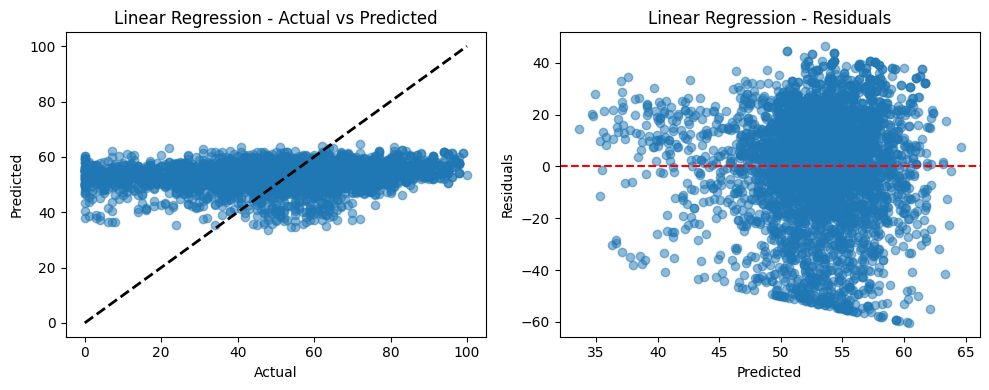

Ridge Regression: MSE=464.36, R2=0.04


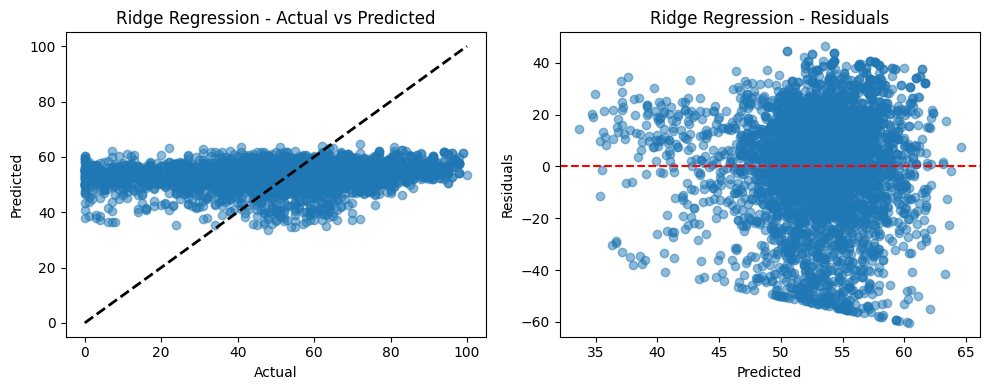

Lasso Regression: MSE=464.36, R2=0.04


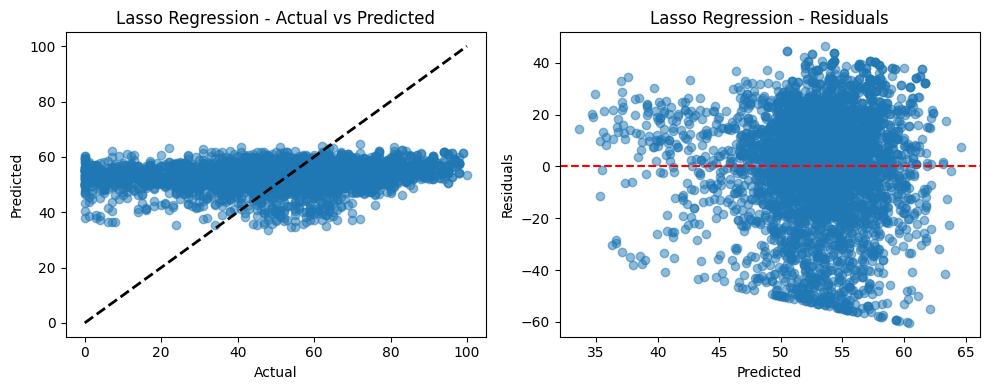

Random Forest: MSE=325.99, R2=0.32


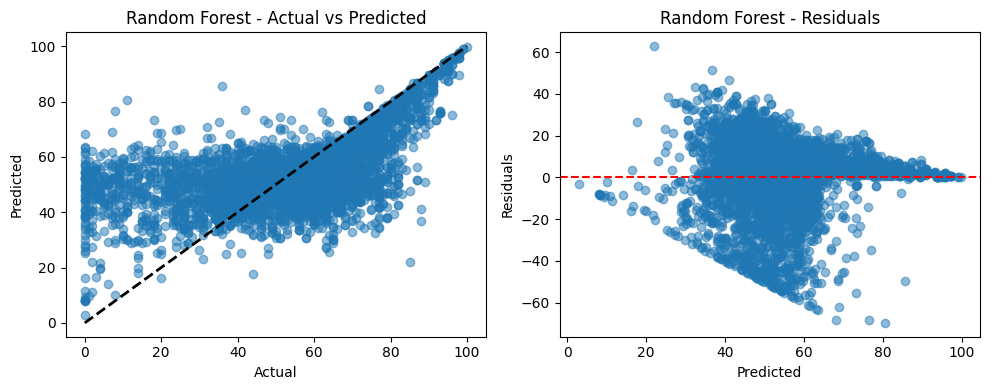

In [19]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    # Hyperparameter tuning for Ridge, Lasso, and Random Forest
    if name in ["Ridge Regression", "Lasso Regression"]:
        params = {'alpha': np.logspace(-4, 4, 10)}
        grid = GridSearchCV(model, param_grid=params, scoring='r2', cv=5)
        grid.fit(X_train_scaled, y_train)
        model = grid.best_estimator_
    elif name == "Random Forest":
        params = {'n_estimators': [100, 200, 500], 'max_depth': [5, 10, 20]}
        grid = GridSearchCV(model, param_grid=params, scoring='r2', cv=5)
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
    else:
        model.fit(X_train_scaled, y_train)

    # Predictions
    if name in ["Linear Regression", "Ridge Regression", "Lasso Regression"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R2": r2}
    print(f"{name}: MSE={mse:.2f}, R2={r2:.2f}")

    # Visualizations: Actual vs Predicted, Residual plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.title(f"{name} - Actual vs Predicted")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{name} - Residuals")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.show()

Feature Importance (Top Features):
loudness            0.105921
danceability        0.098546
audio_valence       0.098142
acousticness        0.095277
song_duration_ms    0.092983
energy              0.092314
instrumentalness    0.090814
tempo               0.090015
speechiness         0.089205
liveness            0.089179
key                 0.043239
audio_mode          0.009325
time_signature      0.005039
dtype: float64


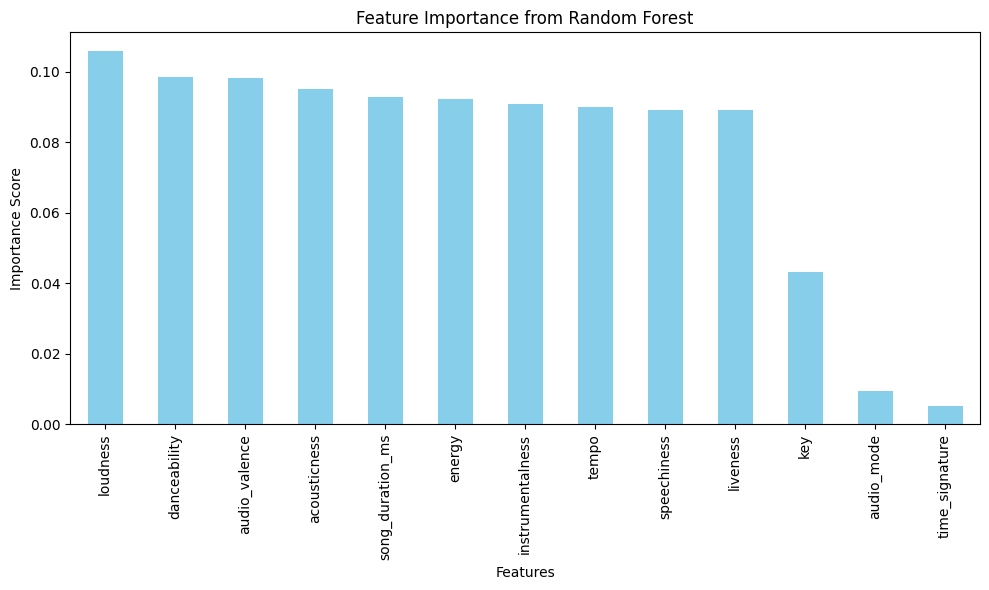

In [20]:
# # Feature Importance for Random Forest
# rf_model = models["Random Forest"]
# rf_model.fit(X_train, y_train)
# importances = pd.Series(rf_model.feature_importances_, index=selected_features).sort_values(ascending=False)

# Define features (X) and target (y)
X = song_data.drop(columns=['song_popularity'])
y = song_data['song_popularity']

# Train a Random Forest model
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X, y)

# Extract feature importance
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print the top features
print("Feature Importance (Top Features):")
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance Score")
plt.show()

In [ ]:
# Compare model performance
performance_df = pd.DataFrame(results).T
performance_df.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.show()